# Classification of Wind Gusts

In [2]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy import feature as cfeature
import pickle

### Open saved metar dataframe

In [3]:
met_df = pd.read_pickle('metar_20190801_df.pkl')

### Creating GustLevel

Can be used to train a classification model. 

In [4]:
met_df = met_df.round(4)
met_df = met_df.replace(np.NaN, 0)
met_df['GustLevel'] = pd.cut(met_df.MetWindGust, bins=[0, 5, 10, 100], labels=False, right=True, include_lowest=True)
met_df

,MetWindGust,Longitude,Latitude,Temperature,WindSpeed,WindDirection,Pressure,GustLevel
0,0.0,-110.85,31.42,297.05,0.0,0.0,101350.0,0
1,0.0,-110.96,32.13,300.35,2.6,170.0,101290.0,0
2,0.0,-111.17,32.14,299.15,2.1,70.0,0.0,0
3,0.0,-111.21,32.40,300.65,2.1,300.0,0.0,0
4,0.0,-116.98,32.57,290.95,1.5,0.0,101430.0,0
...,...,...,...,...,...,...,...,...
4389,0.0,-72.27,42.57,294.25,0.0,0.0,0.0,0
4390,0.0,-71.18,44.58,289.85,0.0,0.0,0.0,0
4391,0.0,-71.70,48.58,289.45,3.1,350.0,101660.0,0
4392,0.0,-73.34,49.28,284.85,0.0,0.0,101730.0,0


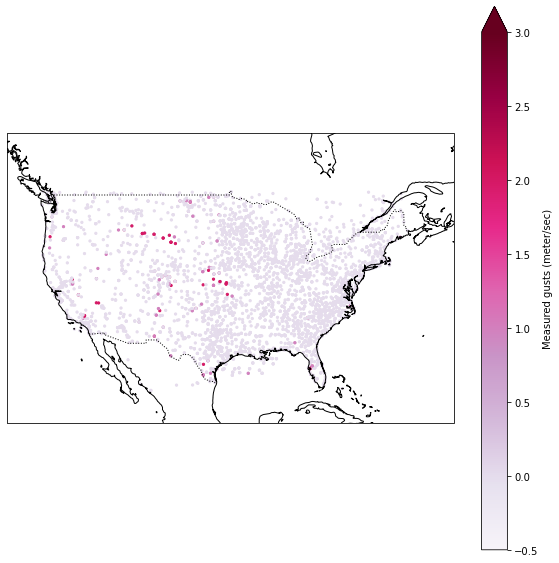

In [5]:
fig = plt.figure(figsize=(10, 10), facecolor='w')
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([-130, -60, 20, 55], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

plt.scatter(met_df.Longitude, met_df.Latitude, c=met_df.GustLevel,
          cmap='PuRd', vmin=-0.5, vmax=3, s=5, transform=ccrs.PlateCarree())

plt.colorbar(label='Measured gusts (meter/sec)', extend='max')
plt.show()